In [1]:
import numpy as np
import xarray as xr 
from tqdm import tqdm
import matplotlib.pyplot as plt
import matplotlib as mpl
import cartopy.crs as ccrs
import cartopy.feature as cf
import glob
import dask.array as da
import time
import seaborn as sns
import pandas as pd
import matplotlib.path as mpath
# colormaps
import cmaps
from cmcrameri import cm
import cmasher as cmr
import cmocean

In [ ]:
from dask.distributed import Client
client = Client(scheduler_file= '/home/huanglei/proj_pyncl/CESM2-LENS/scheduler.json')
client

<Client: 'tcp://203.247.189.224:41018' processes=16 threads=576, memory=298.02 GiB>

In [ ]:
def def_process_coords(exceptcv=[]):
    def process_coords(ds, except_coord_vars=exceptcv):
        coord_vars = []
        for v in np.array(ds.coords):
            if not v in except_coord_vars:
                coord_vars += [v]
        for v in np.array(ds.data_vars):
            if not v in except_coord_vars:
                coord_vars += [v]
        return ds.drop(coord_vars)
    return process_coords

In [ ]:
## define function to read in files
def read_in(var, exceptcv, domain='lnd/', freq='day_1/', stream='h6', chunks=dict(time=365), ens_s=-20, ens_e=-10):
    ens_dir = "the_path_to_yourdirectory_store_data"
    histens_names = [member.split('archive/')[1][:-1]
                     for member in sorted(glob.glob(ens_dir + "b.e21.BHIST*LE2*[!old][!tmp]/"))][10:]
    projens_names = [member.split('archive/')[1][:-1] for member in sorted(
        glob.glob(ens_dir + "b.e21.BSSP370*.f09_g17*[!old][!tmp]/"))][10:]
    hist_ncfiles = []
    proj_ncfiles = []
    for i in np.arange(ens_s, ens_e):
        hist_fnames = sorted(glob.glob(
            ens_dir + histens_names[i] + "/" + domain + "proc/tseries/" + freq + "*" + stream + var + "*"))
        proj_fnames = sorted(glob.glob(
            ens_dir + projens_names[i] + "/" + domain + "proc/tseries/" + freq + "*" + stream + var + "*"))
        hist_ncfiles.append(hist_fnames)
        proj_ncfiles.append(proj_fnames)
    ens_numbers = [members.split('LE2-')[1]
                   for members in histens_names][ens_s:ens_e]
    hist_ds = xr.open_mfdataset(hist_ncfiles,
                                chunks=chunks,
                                preprocess=def_process_coords(exceptcv),
                                combine='nested',
                                concat_dim=[[*ens_numbers], 'time'],
                                parallel=True)
    proj_ds = xr.open_mfdataset(proj_ncfiles,
                                chunks=chunks,
                                preprocess=def_process_coords(exceptcv),
                                combine='nested',
                                concat_dim=[[*ens_numbers], 'time'],
                                parallel=True)
    if freq == 'day_1/':
        hist_ds = hist_ds.isel(time=np.arange(1, hist_ds.time.shape[0]))
        proj_ds = proj_ds.isel(time=np.arange(1, proj_ds.time.shape[0]))
        hist_ds['time'] = hist_ds.time.get_index('time').shift(-1, 'D')
        proj_ds['time'] = proj_ds.time.get_index('time').shift(-1, 'D')
    if freq == 'month_1/':
        hist_ds['time'] = hist_ds.time.get_index('time').shift(-1, 'M')
        proj_ds['time'] = proj_ds.time.get_index('time').shift(-1, 'M')
    ens_ds = xr.concat((hist_ds, proj_ds), 'time')
    ens_ds = ens_ds.rename({'concat_dim': 'ensemble'})
    return ens_ds


In [ ]:
lake_ixy = xr.open_dataarray('/your_path/lake_ixy.nc')
lake_jxy = xr.open_dataarray('/your_path/lake_jxy.nc')


# read in data

In [ ]:
variables = ['TLAKE']
exceptcv = ['time', 'levlak','lat', 'lon', *variables]
tlake_day_ds = read_in(var = '.TLAKE.', 
                    exceptcv = exceptcv,
                     domain = 'lnd/',
                     freq = 'day_1/',
                     stream = 'h5',
                    ens_s = 0,
                    ens_e = 90) # 90 out of 100 members have daily data that allows our analysis

variables = ['LAKEICETHICK']
exceptcv = ['time', 'lat', 'lon', *variables]
ice_day_ds = read_in(var = '.LAKEICETHICK.', 
                    exceptcv = exceptcv,
                     domain = 'lnd/',
                     freq = 'day_1/',
                     stream = 'h5',
                    ens_s = 0,
                    ens_e = 90)

variables = ['JCONVECT']
exceptcv = ['time', 'lat', 'lon', *variables]
jconv_day_ds = read_in(var = '.JCONVECT.', 
                    exceptcv = exceptcv,
                     domain = 'lnd/',
                     freq = 'day_1/',
                     stream = 'h5',
                    ens_s = 0,
                    ens_e = 90)

/home/huanglei/usr/anaconda3/envs/Jun2023/lib/python3.9/site-packages/xarray/core/indexing.py:1440: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  return self.array[key]


In [ ]:
# this is the read_in dataset look like (taking TLAKE as an example), you may want to read the original data from CESM2-LE output following the same 
# method, to make sure the dimension of arrays be the same, so that you can use this script to reproduce all the analysis
tlake_day_ds

<xarray.Dataset>
Dimensions:   (levlak: 10, lon: 288, lat: 192, time: 91615, ensemble: 90)
Coordinates:
  * levlak    (levlak) float32 0.05 0.6 2.1 4.6 8.1 12.6 18.6 25.6 34.33 44.78
  * lon       (lon) float32 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
  * lat       (lat) float32 -90.0 -89.06 -88.12 -87.17 ... 88.12 89.06 90.0
  * time      (time) object 1850-01-01 00:00:00 ... 2100-12-31 00:00:00
  * ensemble  (ensemble) object '1231.001' '1231.002' ... '1301.019' '1301.020'
Data variables:
    TLAKE     (ensemble, time, levlak, lat, lon) float32 dask.array<chunksize=(1, 364, 10, 192, 288), meta=np.ndarray>
Attributes: (12/100)
    title:                                     CLM History file information
    comment:                                   NOTE: None of the variables ar...
    Conventions:                               CF-1.0
    history:                                   created on 03/13/20 13:57:49
    source:                                    Community Land Model CLM4.0
    hostname:                                  aleph
    ...                                        ...
    cft_irrigated_switchgrass:                 60
    cft_tropical_corn:                         61
    cft_irrigated_tropical_corn:               62
    cft_tropical_soybean:                      63
    cft_irrigated_tropical_soybean:            64
    time_period_freq:                          day_1

In [ ]:
'''since we only care about ice covred lakes, thus build the mask for ice cover first'''
ice_ann_climmean_1850s = (ice_day_ds.LAKEICETHICK[-20:,:3650,:,:] > 0).groupby('time.year').sum('time', skipna=True).mean('year').mean('ensemble').compute().where(~np.isnan(ice_day_ds.LAKEICETHICK[0,0,...].drop(('ensemble','time')).compute()))
ice_ann_climmean_1850s_lunit = ice_ann_climmean_1850s[lake_jxy,lake_ixy]

# calculate changes in ensemble mean of stratification and overturning occurences for each day

In [22]:
strat_daymean_1850_lunit = (xr.apply_ufunc(lambda x: x.max() - x[x > 0].min(),
              tlake_day_ds.TLAKE[:,:365,:,lake_jxy,lake_ixy].chunk({'ensemble':1,'time':30,'landunit':500}),
              input_core_dims=[['levlak'],],
             exclude_dims=set(('levlak',)),
              vectorize = True,
              dask='parallelized',
              output_dtypes=['float32']) > 1).mean('ensemble').groupby('time.dayofyear').sum('time')[:,1000:][:,ice_ann_climmean_1850s_lunit[1000:].values > 0]

strat_daymean_2096_lunit = (xr.apply_ufunc(lambda x: x.max() - x[x > 0].min(),
              tlake_day_ds.TLAKE[:,:,:,lake_jxy,lake_ixy].sel(time = slice('2096-01-01','2096-12-31')).chunk({'ensemble':1,'time':30,'landunit':500}),
              input_core_dims=[['levlak'],],
             exclude_dims=set(('levlak',)),
              vectorize = True,
              dask='parallelized',
              output_dtypes=['float32']) > 1).mean('ensemble').groupby('time.dayofyear').sum('time')[:,1000:][:,ice_ann_climmean_1850s_lunit[1000:].values > 0]


strat_daymean_changes_2096_lunit = (strat_daymean_2096_lunit - strat_daymean_1850_lunit).compute()

strat_daymean_changes_2096_lunit = strat_daymean_changes_2096_lunit.assign_coords({'landunit':np.arange(strat_daymean_changes_2096_lunit.landunit.size)})

/home/huanglei/usr/anaconda3/envs/Jun2023/lib/python3.9/site-packages/distributed/client.py:3106: UserWarning: Sending large graph of size 17.78 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


In [23]:
overturn_jconv_daymean_1850_lunit = (jconv_day_ds.JCONVECT[:,:,lake_jxy, lake_ixy].sel(time = slice('1850-01-01','1850-12-31')) > 8).mean('ensemble').groupby('time.dayofyear').sum('time')[:,1000:][:,ice_ann_climmean_1850s_lunit[1000:].values > 0]
overturn_jconv_daymean_2096_lunit = (jconv_day_ds.JCONVECT[:,:,lake_jxy, lake_ixy].sel(time = slice('2096-01-01','2096-12-31')) > 8).mean('ensemble').groupby('time.dayofyear').sum('time')[:,1000:][:,ice_ann_climmean_1850s_lunit[1000:].values > 0]
overturn_jconv_daymean_changes_2096_lunit = (overturn_jconv_daymean_2096_lunit - overturn_jconv_daymean_1850_lunit).compute()

overturn_jconv_daymean_changes_2096_lunit = overturn_jconv_daymean_changes_2096_lunit.assign_coords({'landunit':np.arange(overturn_jconv_daymean_changes_2096_lunit.landunit.size)})

/home/huanglei/usr/anaconda3/envs/Jun2023/lib/python3.9/site-packages/distributed/client.py:3106: UserWarning: Sending large graph of size 12.00 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Figure S10

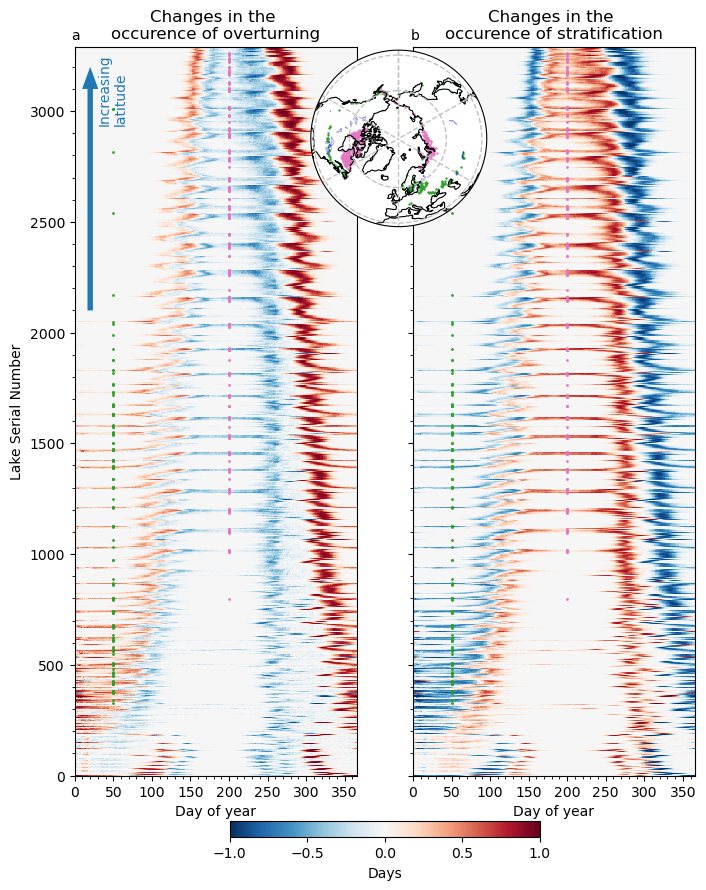

In [31]:
a = overturn_jconv_daymean_changes_2096_lunit.landunit[(overturn_jconv_daymean_changes_2096_lunit > 0.1 ).sum('dayofyear') > 100]
b = strat_daymean_changes_2096_lunit.landunit[(strat_daymean_changes_2096_lunit > 0.2).sum('dayofyear') > 80]
ax = overturn_jconv_daymean_changes_2096_lunit.lon[(overturn_jconv_daymean_changes_2096_lunit > 0.1 ).sum('dayofyear') > 100]
ay = overturn_jconv_daymean_changes_2096_lunit.lat[(overturn_jconv_daymean_changes_2096_lunit > 0.1 ).sum('dayofyear') > 100]
bx = strat_daymean_changes_2096_lunit.lon[(strat_daymean_changes_2096_lunit > 0.2).sum('dayofyear') > 80]
by = strat_daymean_changes_2096_lunit.lat[(strat_daymean_changes_2096_lunit > 0.2).sum('dayofyear') > 80]
#---------------------------------------------------------------------- 
fig = plt.figure(figsize = (8,16))
gs = mpl.gridspec.GridSpec(4,2,figure = fig)
ax0 = fig.add_subplot(gs[:3,0])
ax1 = fig.add_subplot(gs[:3,1])
ax3 = fig.add_axes([0.42,0.713,0.22,0.22], projection = ccrs.Orthographic(central_latitude = 90))
#---------------------------------------------------------------------- 
p1 = overturn_jconv_daymean_changes_2096_lunit.T.plot(ax = ax0, vmin = -1, vmax = 1, cmap = 'RdBu_r', add_colorbar = False)
ax0.scatter(np.ones(a.size) * 50, a, s = 1, color = 'C2')
ax0.scatter(np.ones(b.size) * 200, b, s = 1, color = 'C6')
ax0.set_ylabel('Lake Serial Number')
ax0.set_xlabel('Day of year')
ax0.set_xticks(np.arange(0,365,50))
ax0.minorticks_on()
ax0.set_title('Changes in the \noccurence of overturning')
#---------------------------------------------------------------------- 
p2 = strat_daymean_changes_2096_lunit.T.plot(ax = ax1, vmin = -1, vmax = 1, cmap = 'RdBu_r', add_colorbar = False)
ax1.scatter(np.ones(a.size) * 50, a, s = 1, color = 'C2')
ax1.scatter(np.ones(b.size) * 200, b, s = 1, color = 'C6')
ax1.set_ylabel(None)
ax1.set_xlabel('Day of year')
ax1.set_xticks(np.arange(0,365,50))
ax1.minorticks_on()
ax1.set_yticklabels([])
ax1.set_title('Changes in the \noccurence of stratification')
#---------------------------------------------------------------------- 
cb = fig.colorbar(p2, ax = [ax0, ax1], shrink = 0.5, location = 'bottom', pad = 0.05)
cb.set_label('Days')
ax0.arrow(20, 2100, 0, 1000, width = 7, edgecolor = 'none', facecolor = 'C0', head_length = 100, overhang = 0)
ax0.text(29, 2950, 'Increasing\nlatitude', rotation = 'vertical', color = 'C0')
#---------------------------------------------------------------------- 
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)
ax3.set_extent([-180, 180, 23.5, 90], ccrs.PlateCarree())
ax3.set_boundary(circle, transform=ax3.transAxes)
ax3.coastlines(linewidths = 0.8)
ax3.gridlines(crs = ccrs.PlateCarree(), draw_labels = False, color = '#c2c2c2', linestyle='--', ylocs = (30,60), lw = 1)
ax3.add_feature(cf.NaturalEarthFeature('physical','lakes','110m'), linewidths=0.2, facecolor='None',edgecolor='Blue')
ax3.scatter(ax,
            ay,
            c = 'C2',
            transform = ccrs.PlateCarree(),
            s = 0.5)
ax3.scatter(bx,
            by,
            c = 'C6',
            transform = ccrs.PlateCarree(),
            s = 0.5)
#---------------------------------------------------------------------- 
fig.text(0.12,0.885, 'a')
fig.text(0.545,0.885, 'b')
#---------------------------------------------------------------------- 
plt.show()